In [19]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.datasets import load_diabetes

from IPython.display import clear_output

## Третье задание

In [2]:
# шаг градиентного спуска
def make_L1_iter(X, y, w, mu=0.1, alpha=0.1):
    grad = 2 * (X @ w - y) @ X + 2 * mu * np.sign(w)
    return w - alpha * grad

In [3]:
N = 150
MAX_OREDER = 5

x = np.linspace(0, 1, N)
print(x.shape)

poly = PolynomialFeatures(MAX_OREDER)
X = poly.fit_transform(x.reshape(N, 1))
Xn = (X - np.mean(X, axis=0)) / (np.std(X, axis=0)+1)
Xn[:, 0] += 1
Xn = np.hstack([Xn,Xn/2]) #добавим линейно зависимых признаков

print("X shape:", Xn.shape)

(150,)
X shape: (150, 12)


(150,)


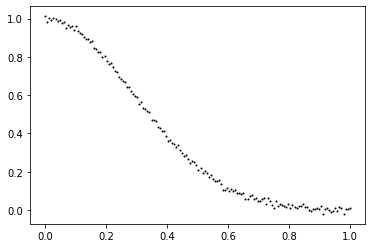

In [4]:
# вот такую функию будем приближать
y = np.cos(7 * x) + np.random.normal(0, 1e-1, x.shape)
y = np.exp(-6 * x**2) + np.random.normal(0, 1e-2, x.shape)
print(y.shape)

plt.scatter(x, y, color="k", s=1)
plt.show()

In [5]:
# попрубуем для начала обучиться функцией из коробки
reg = LassoCV(cv=5).fit(Xn, y)
clear_output()
print(reg.score(Xn, y)) # примерно такой score будем считать приемлемым

0.9909324532288012


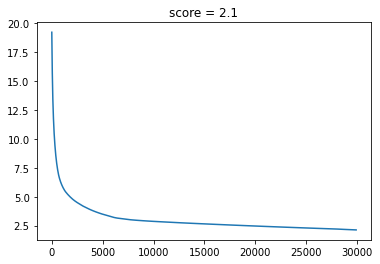

In [6]:
# попробуем для начала просто обучиться
alpha_val = 2e-5
w0 = np.random.normal(0, 0.1, Xn.shape[1])
w = make_L1_iter(Xn, y, w0, mu=0.1, alpha=alpha_val)


ress = []
for i in range(30000):
    w = make_L1_iter(Xn, y, w, mu=1, alpha=alpha_val)
    score = np.sum((Xn @ w - y)**2)
    ress.append(score)
    
# plt.plot(np.log(ress))
plt.plot(ress[100:])
plt.title("score = {:.1f}".format(ress[-1]))
plt.show()

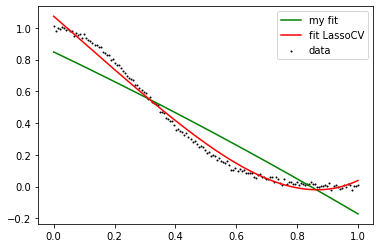

In [7]:
# в некотором смысле получил что-то совпадающее
plt.plot(x, Xn @ w, label="my fit", color="g")
plt.plot(x, reg.predict(Xn), label="fit LassoCV", color="r")
plt.scatter(x, y, label="data", color="k", s=1)
plt.legend()
plt.show()

### KFold

In [8]:
def TrainReg(X, y, mu=0.1, alpha=2e-5, n_iter=30000):
    w0 = np.random.normal(0, 0.1, X.shape[1])
    w = make_L1_iter(X, y, w0, mu=mu, alpha=alpha)
    
    ress = []
    for i in range(n_iter):
        w = make_L1_iter(X, y, w, mu=mu, alpha=alpha)
        score = np.sum((X @ w - y)**2)
        ress.append(score)
    return w

In [9]:
def GetLoss(X, y, w):
    return np.sum((X @ w - y)**2)

In [10]:
K = 3
kf = KFold(K, shuffle=True)
cross_val_res = []

for mu in [0.01, 1, 10]:
    for alpha in [1e-6, 1e-4, 1e-3]:
        scors = []
        for train, test in kf.split(Xn):
            X_train, X_test, y_train, y_test = Xn[train], Xn[test], y[train], y[test]
            
            w = TrainReg(X_train, y_train, mu=mu, alpha=alpha, n_iter=30000)
            scors.append(GetLoss(X_test, y_test, w))
        score = np.mean(scors)
        delta = np.std(scors)
        print("mu = {:.2e}, alpha = {:.1e}, score = {:.2f} +- {:.2f}".format(
            mu, alpha, score, delta))
        cross_val_res.append([score, mu, alpha])

mu = 1.00e-02, alpha = 1.0e-06, score = 1.94 +- 0.07
mu = 1.00e-02, alpha = 1.0e-04, score = 0.07 +- 0.01
mu = 1.00e-02, alpha = 1.0e-03, score = 0.05 +- 0.01
mu = 1.00e+00, alpha = 1.0e-06, score = 2.50 +- 0.29
mu = 1.00e+00, alpha = 1.0e-04, score = 0.64 +- 0.02
mu = 1.00e+00, alpha = 1.0e-03, score = 0.65 +- 0.12
mu = 1.00e+01, alpha = 1.0e-06, score = 6.89 +- 0.50
mu = 1.00e+01, alpha = 1.0e-04, score = 6.93 +- 1.38
mu = 1.00e+01, alpha = 1.0e-03, score = 6.63 +- 1.30


In [12]:
cross_val_res = np.array(cross_val_res)
sorted_cross_val_res = cross_val_res[np.argsort(cross_val_res[:, 0])]
np.log10(sorted_cross_val_res)

array([[-1.26930774, -2.        , -3.        ],
       [-1.13383908, -2.        , -4.        ],
       [-0.19249058,  0.        , -4.        ],
       [-0.18697381,  0.        , -3.        ],
       [ 0.28688416, -2.        , -6.        ],
       [ 0.39734765,  0.        , -6.        ],
       [ 0.82123634,  1.        , -3.        ],
       [ 0.83841443,  1.        , -6.        ],
       [ 0.84095384,  1.        , -4.        ]])

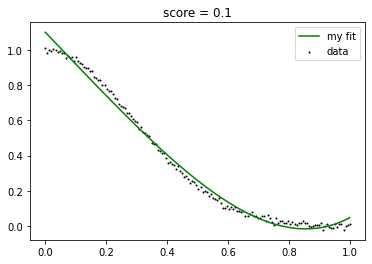

In [14]:
# вот, через KFold нашли параметры, приблизившие нас к коробочному варианту
mu_KFold, alpha_KFold = sorted_cross_val_res[0][1:]

w = TrainReg(Xn, y, mu=mu_KFold, alpha=alpha_KFold, n_iter=30000)
plt.plot(x, Xn @ w, label="my fit", color="g")
plt.scatter(x, y, label="data", color="k", s=1)
plt.legend()
plt.title("score = {:.1f}".format(GetLoss(Xn, y, w)))
plt.show()

## Четвертое задание

In [20]:
data = sk.datasets.load_diabetes()
print(list(data.keys()))
X = data["data"]
y = data["target"]
print(X.shape)
print(y.shape)

['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename']
(442, 10)
(442,)


In [21]:
# тестовый запуск
alpha0 = 1e-7
scors = []
reg5 = linear_model.Lasso(alpha=alpha0)
reg5.fit(X, y)
scors.append(np.sum((reg5.predict(X) - y)**2))
vals = reg5.coef_
print(vals.shape)

# смотрим на веса при разных alpha
alphas = np.linspace(alpha0, 3, 200)
for alpha in alphas:
    reg5 = linear_model.Lasso(alpha=alpha)
    reg5.fit(X, y)
    scors.append(np.sum((reg5.predict(X) - y)**2))
    vals = np.vstack([vals, reg5.coef_])
    
alphas = np.hstack([[alpha0], alphas])

(10,)


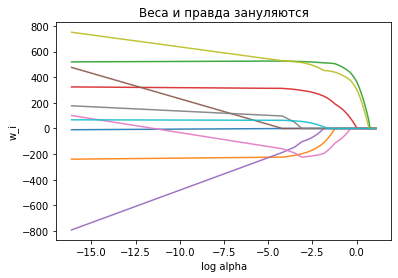

In [22]:
for i in range(vals.shape[1]):
    plt.plot(np.log(alphas), vals[:, i], alpha=0.9)

plt.title("Веса и правда зануляются")
plt.xlabel("log alpha")
plt.ylabel("w_i")
plt.show()

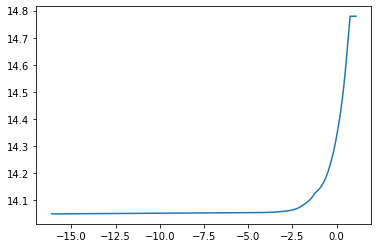

In [23]:
# модели становится хуже
plt.plot(np.log(alphas), np.log(scors))
plt.show()